In [1]:
#importing libraries 
import pandas as pd
import numpy as np

import os
import sys

import librosa.display #used to extract the features 
import seaborn as sns #data visualization
import matplotlib.pyplot as plt #data visualization

# package used to play audio files
from IPython.display import Audio

#packages for model developmment
from sklearn.preprocessing import StandardScaler, OneHotEncoder #encoding label variable and data standartization
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [2]:
#Important functions 

#Function to create a wave plot of a sound
def wavePlot(data, sr, e):
    plt.figure(figsize=(14, 5))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
#Data Augmentation functions
#1. Noise addition 
def noiseInjection(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
#Time stretching
def timeStretch(data):
    return librosa.effects.time_stretch(data, rate=0.7)

def pitchShifting(data, sampling_rate):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=0.7)

#Feature Extraction 
def setFeatures(data):
    #Creating empty array for features 
    features = np.array([])
    #1.Zero Crossing Rate 
    zeroCrossRate = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    features=np.hstack((features, zeroCrossRate)) 
    #2.Root Mean Square 
    rootMeanSquare = np.mean(librosa.feature.rms(y=data).T, axis=0)
    #appending new extracted feature 
    features = np.hstack((features, rootMeanSquare)) 
    #3.Spectral Centroid 
    spectralCentroid=np.mean(librosa.feature.spectral_centroid(y=data,sr=sr).T,axis=0)
    features=np.hstack((features,spectralCentroid)) 
    #4.MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    features = np.hstack((features, mfcc))
    return features 
##Feature Retrievement 
def getFeatures(dataPath):
    data,sr=librosa.load(dataPath,offset=0.6, duration=2.4)
    #no data augmentation
    featuresNDA=np.array(setFeatures(data)) #featuresNDA-features with No Data Augmentation
    features=np.array(featuresNDA)
    
    #adding noise injection 
    noiseTemp=setFeatures(noiseInjection(data)) #creating temporary variable 
    temp=np.vstack((features,noiseTemp))
    
    #time stretching and pitching
    temp1=pitchShifting(timeStretch(data),sr) 
    tempResult=setFeatures(temp1)
    features=np.vstack((features,tempResult))
    
    return features

In [3]:
#Data Loading 
#Variable to store the path to all audio files
dataPath="/Users/leylihashimova/Desktop/Dissertation/AudioData/ALL/"
audioData= os.listdir(dataPath)

#Two emmpty arrays to store the path of each audio file and the emotion expressed 
emotion = []
path = []
#Separation of the emotions according to the file name
for i in audioData:
    path.append(dataPath + i)
    part = i.split('_')[1]
    z = part[:-6]
    if z=='a':
        emotion.append('anger')
    elif z=='f':
        emotion.append('fear')
    elif z=='n':
        emotion.append('neutral')
    elif z=='h':
        emotion.append('happiness')
    elif z=='su':
        emotion.append('surprise')
    elif z=='d':
        emotion.append('disgust')
    else:
        emotion.append('sad')
        

emotionDf = pd.DataFrame(emotion, columns=['Emotion']) #emotion data frame
pathDf = pd.DataFrame(path, columns=['Path']) #file path data frame
audioEmotionDf = pd.concat([emotionDf, pathDf], axis=1) #creating a new data frame by concatinating emotion and file path
audioEmotionDf.head()

#Display the frequency table for emotions 
print(audioEmotionDf)
pd.crosstab(index=audioEmotionDf['Emotion'], columns='count')

      Emotion                                               Path
0         sad  /Users/leylihashimova/Desktop/Dissertation/Aud...
1         sad  /Users/leylihashimova/Desktop/Dissertation/Aud...
2     neutral  /Users/leylihashimova/Desktop/Dissertation/Aud...
3    surprise  /Users/leylihashimova/Desktop/Dissertation/Aud...
4     neutral  /Users/leylihashimova/Desktop/Dissertation/Aud...
..        ...                                                ...
475     anger  /Users/leylihashimova/Desktop/Dissertation/Aud...
476     anger  /Users/leylihashimova/Desktop/Dissertation/Aud...
477   neutral  /Users/leylihashimova/Desktop/Dissertation/Aud...
478  surprise  /Users/leylihashimova/Desktop/Dissertation/Aud...
479  surprise  /Users/leylihashimova/Desktop/Dissertation/Aud...

[480 rows x 2 columns]


col_0      count
Emotion         
anger         60
disgust       60
fear          60
happiness     60
neutral      120
sad           60
surprise      60

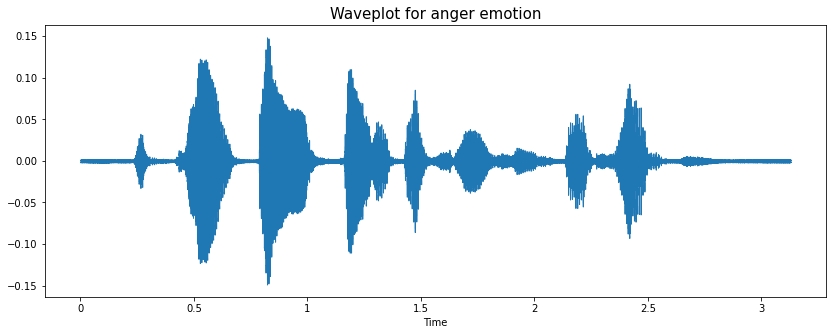

In [4]:
#waveplots and spectograms of each emotion 
#anger
emotion='anger'
path = np.array(audioEmotionDf.Path[audioEmotionDf.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
wavePlot(data, sampling_rate, emotion)
Audio(path)

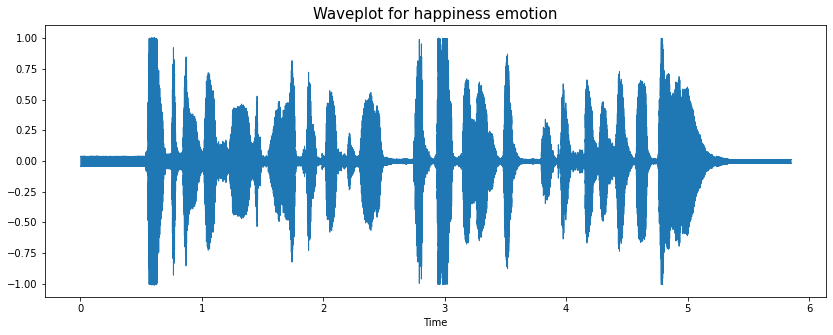

In [5]:
#happiness
emotion='happiness'
path = np.array(audioEmotionDf.Path[audioEmotionDf.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
wavePlot(data, sampling_rate, emotion)
Audio(path)

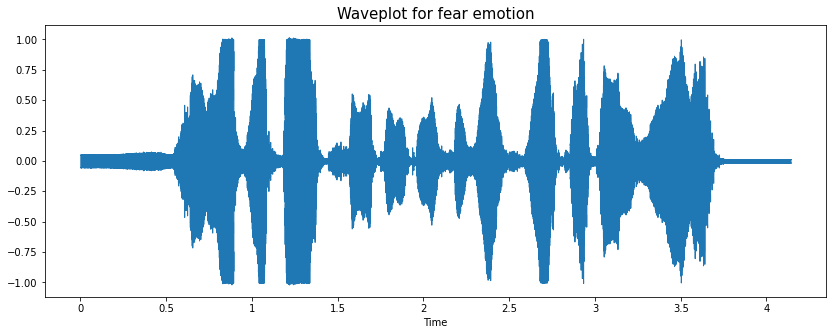

In [6]:
#fear
emotion='fear'
path = np.array(audioEmotionDf.Path[audioEmotionDf.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
wavePlot(data, sampling_rate, emotion)
Audio(path)

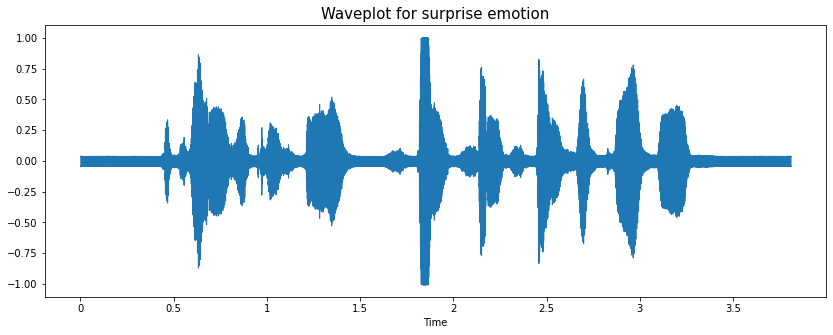

In [7]:
#surprise
emotion='surprise'
path = np.array(audioEmotionDf.Path[audioEmotionDf.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
wavePlot(data, sampling_rate, emotion)
Audio(path)

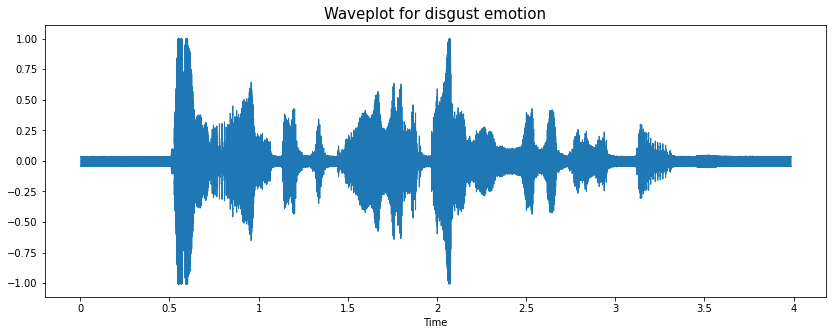

In [8]:
#disgust
emotion='disgust'
path = np.array(audioEmotionDf.Path[audioEmotionDf.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
wavePlot(data, sampling_rate, emotion)
Audio(path)

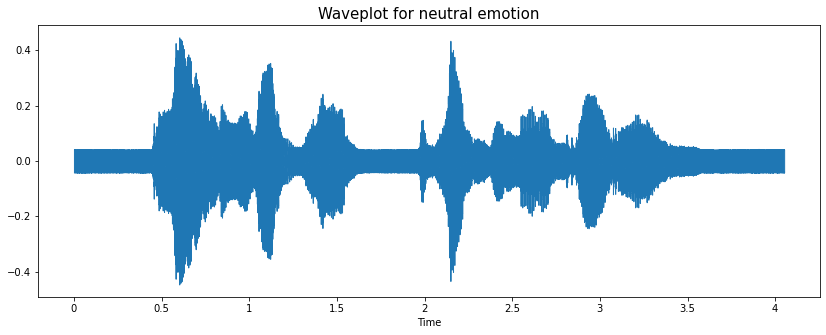

In [9]:
#neutral
emotion='neutral'
path = np.array(audioEmotionDf.Path[audioEmotionDf.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
wavePlot(data, sampling_rate, emotion)
Audio(path)

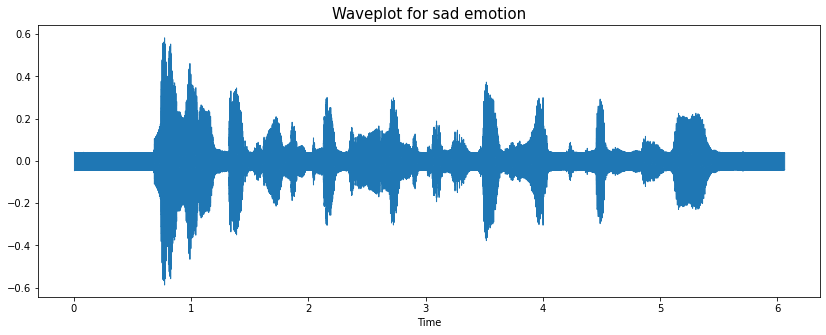

In [10]:
#sadness
emotion='sad'
path = np.array(audioEmotionDf.Path[audioEmotionDf.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
wavePlot(data, sampling_rate, emotion)
Audio(path)

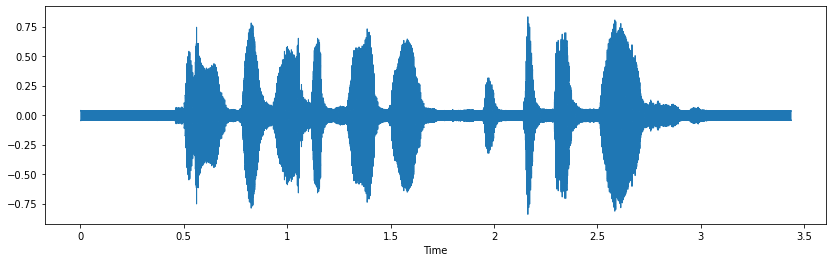

In [11]:
#Now, we can test data augmentation methods
#Functions are written above after imports 

#Testing for the third audio(randomly choosen)
path = np.array(audioEmotionDf.Path)[3]
data, sr = librosa.load(path) #sr is sample rate 
#Wave plot with no data augmentation techniques applied
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=data, sr=sr)
Audio(path)


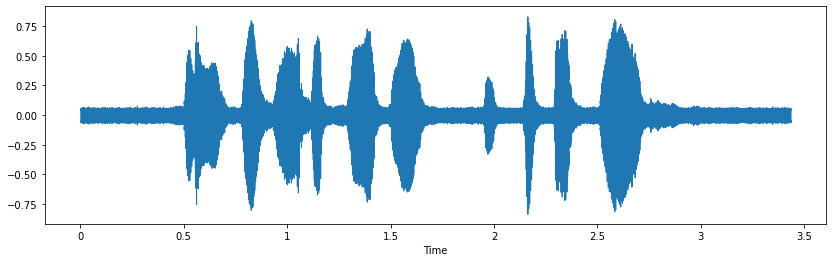

In [12]:
#Noise Injection 
test = noiseInjection(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=test, sr=sr)
Audio(test, rate=sr)

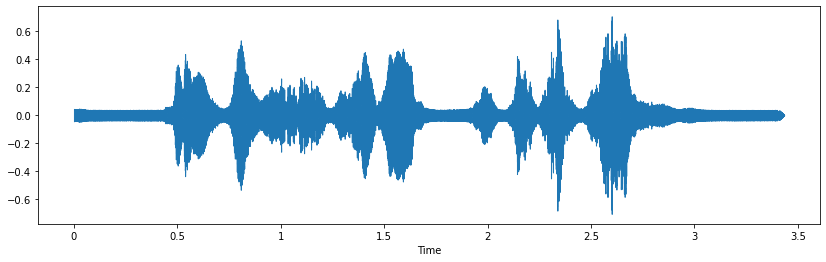

In [13]:
#Pitching
test = pitchShifting(data,sr)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=test, sr=sr)
Audio(test, rate=sr)

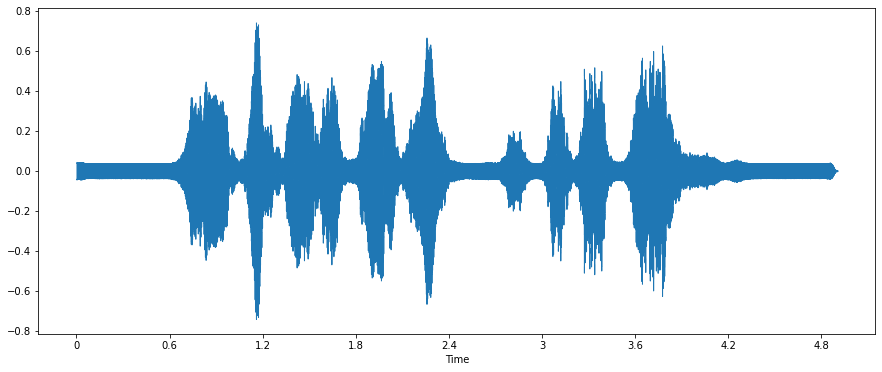

In [14]:
#Time stretching
test = timeStretch(data)
plt.figure(figsize=(15,6))
librosa.display.waveshow(y=test, sr=sr)
Audio(test, rate=sr) 

In [15]:
X, Y = [], []
for path, emotion in zip(audioEmotionDf.Path, audioEmotionDf.Emotion):
    feature = getFeatures(path)
    for i in feature:
        X.append(i)
        Y.append(emotion)

In [16]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv')
Features.head(100)
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [17]:
#Using onehotencoder multiclass variable will be encoded to numerical
oneHotEncoder = OneHotEncoder()
Y = oneHotEncoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y,random_state=0, shuffle=True)


# data standardization using scikit-learn  
standardScaler = StandardScaler()
x_train = standardScaler.fit_transform(x_train)
x_test = standardScaler.transform(x_test)
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((720, 23, 1), (720, 7), (240, 23, 1), (240, 7))

In [18]:
#Model Development 
#CNN
model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1:])))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 23, 256)           1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 256)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 128)            163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 128)           0

In [19]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=60, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/60
12/12 [==============================] - 1s 51ms/step - loss: 1.9052 - accuracy: 0.2236 - val_loss: 1.8525 - val_accuracy: 0.2042 - lr: 0.0010
Epoch 2/60
12/12 [==============================] - 0s 20ms/step - loss: 1.7596 - accuracy: 0.2972 - val_loss: 1.6988 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 3/60
12/12 [==============================] - 0s 19ms/step - loss: 1.7048 - accuracy: 0.3125 - val_loss: 1.6515 - val_accuracy: 0.3167 - lr: 0.0010
Epoch 4/60
12/12 [==============================] - 0s 19ms/step - loss: 1.6265 - accuracy: 0.3236 - val_loss: 1.5917 - val_accuracy: 0.3083 - lr: 0.0010
Epoch 5/60
12/12 [==============================] - 0s 19ms/step - loss: 1.5613 - accuracy: 0.3708 - val_loss: 1.5504 - val_accuracy: 0.3417 - lr: 0.0010
Epoch 6/60
12/12 [==============================] - 0s 19ms/step - loss: 1.5445 - accuracy: 0.3694 - val_loss: 1.5084 - val_accuracy: 0.3458 - lr: 0.0010
Epoch 7/60
12/12 [==============================] - 0s 19ms/step - loss: 1.5

In [21]:
print("Accuracy of the CNN model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

8/8 [==============================] - 0s 3ms/step - loss: 1.1989 - accuracy: 0.6667
Accuracy of the CNN model on test data :  66.66666865348816 %


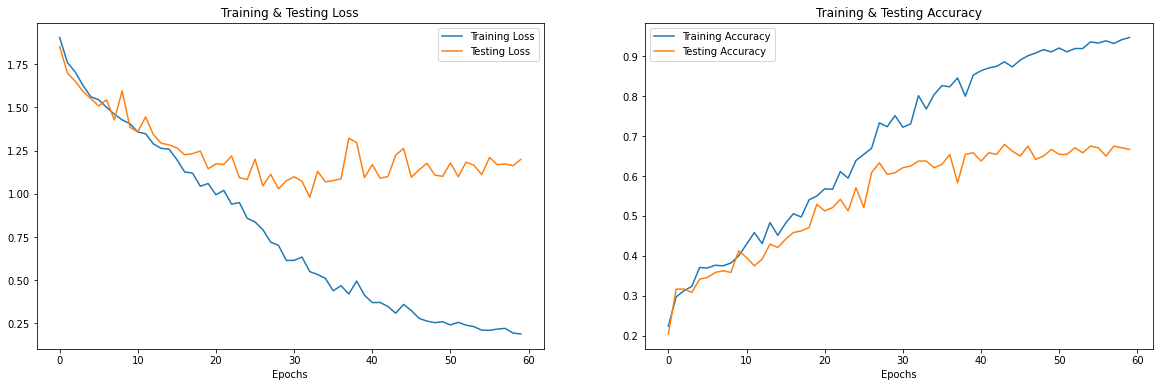

In [22]:
epochs = [i for i in range(60)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [23]:
# predicting on test data.
testPrediction = model.predict(x_test)
y_pred = oneHotEncoder.inverse_transform(testPrediction)

y_test = oneHotEncoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted', 'True'])
df['Predicted'] = y_pred.flatten()
df['True'] = y_test.flatten()

df.head(15)

8/8 [==============================] - 0s 3ms/step


Predicted       True
0       anger      anger
1   happiness      anger
2         sad        sad
3       anger      anger
4     neutral        sad
5       anger      anger
6     neutral    neutral
7     neutral    neutral
8        fear       fear
9     disgust  happiness
10  happiness  happiness
11    disgust       fear
12    neutral    neutral
13   surprise   surprise
14      anger      anger

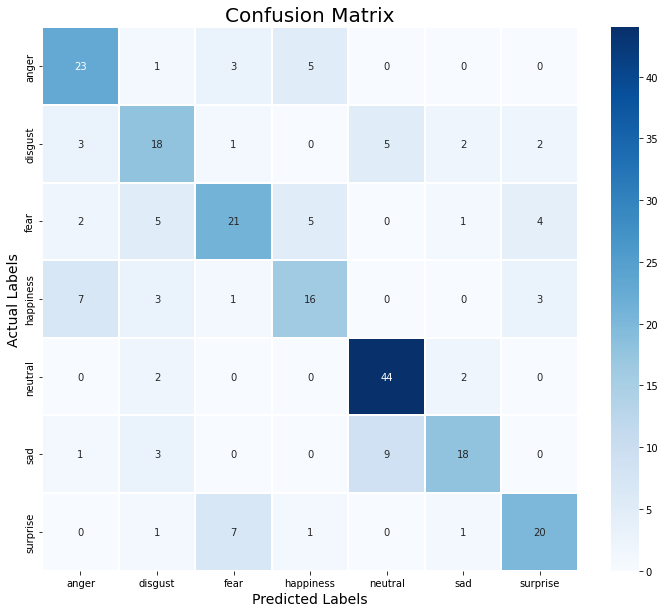

In [27]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in oneHotEncoder.categories_] , columns = [i for i in oneHotEncoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()